In [40]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['figure.figsize'] = (15, 5)

---
# 2-State (Closed $\rightleftarrows$ Open) HMM for an ion channel

### Starting probability in each state:

In [125]:
p0 = np.array([0.5, 0.5])  # P(C), P(O)

### Transition probabilities per time step:

In [126]:
trans = np.array([[0.95, 0.05],   # P(C->C), P(C->O)
                  [0.15, 0.85]])  # P(O->C), P(O->O)

### Emission distributions for each state:

In [127]:
emis = [st.norm(0, 1), st.norm(5, 1)]

---
# HMM Simulation

In [128]:
def simulateHMM(p0, trans, emis, numSamples):
    numStates = len(p0)
    stateIds = range(numStates)  # 0, 1, ..., numStates-1
    
    # preallocate simulation arrays
    states = np.zeros(numSamples, dtype=int)
    observations = np.zeros(numSamples)
    
    # randomly assign starting state
    states[0] = np.random.choice(stateIds, p=p0)
    
    # randomly assign subsequent states based on the transition probabilities
    for t in range(numSamples-1):
        state = states[t]
        states[t+1] = np.random.choice(stateIds, p=trans[state,:])
    
    # randomly draw state observations from emission distributions
    for state in stateIds:
        stateMask = states == state
        observations[stateMask] = emis[state].rvs(stateMask.sum())
    
    return states, observations

In [129]:
states, observations = simulateHMM(p0, trans, emis, 1000)

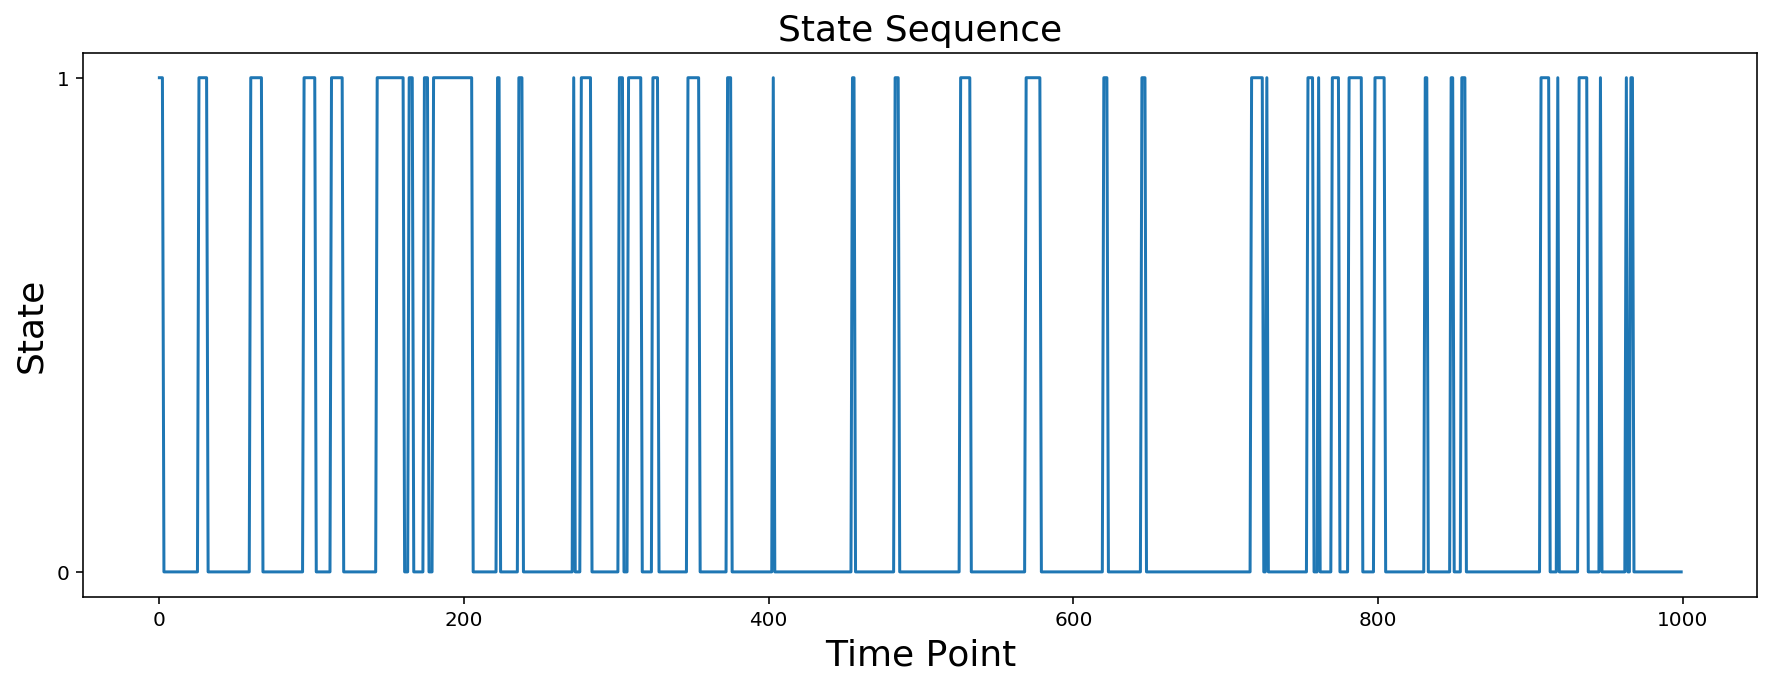

In [130]:
plt.plot(states)
plt.yticks(np.unique(states))
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence');

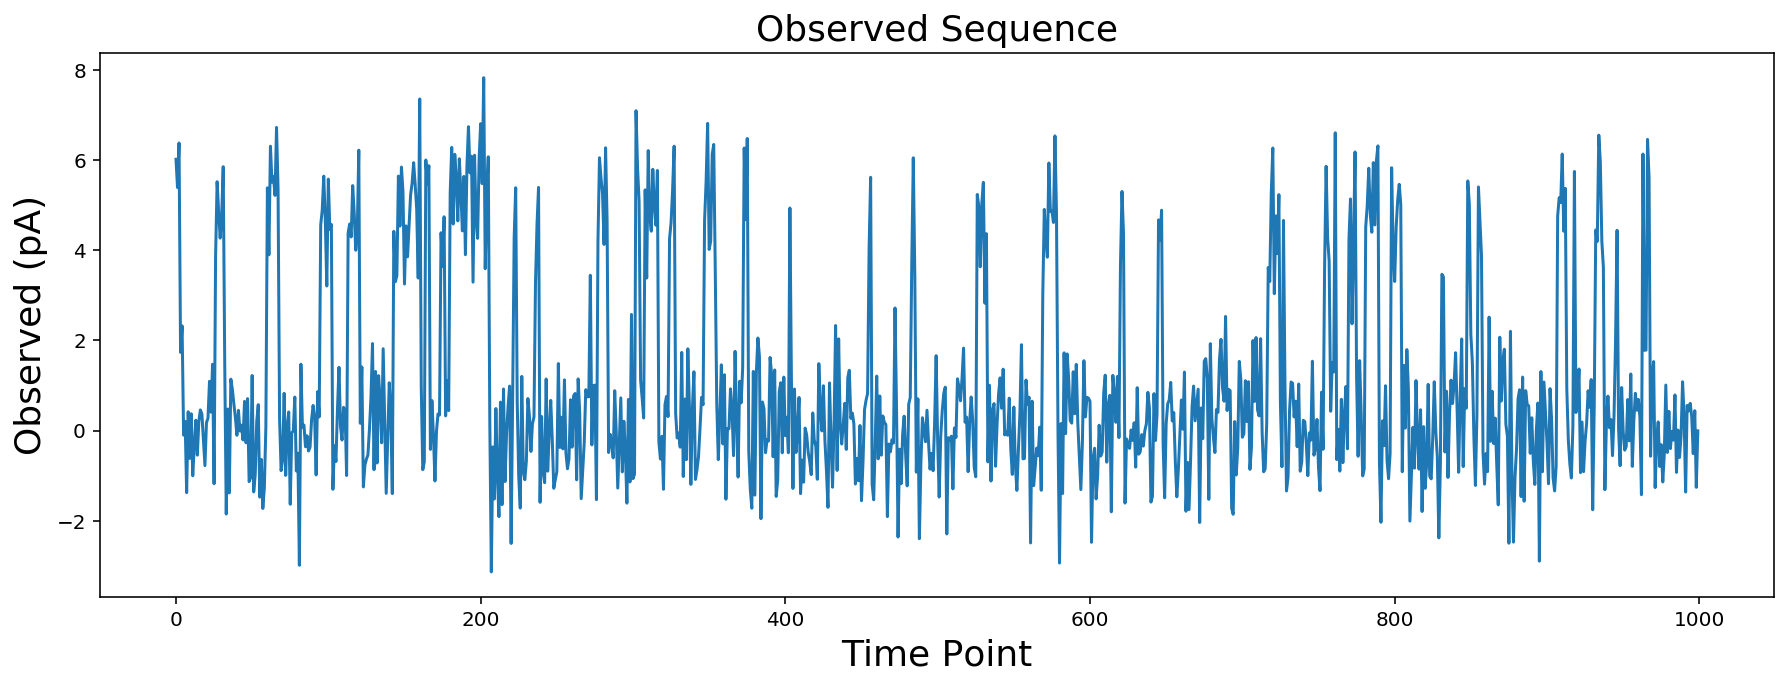

In [131]:
plt.plot(observations)
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Observed Sequence');

---
# Threshold Idealization of Observations

In [132]:
threshold = 2.5
predictedStates = np.zeros(observations.shape, dtype=int)
predictedStates[observations < threshold] = 0
predictedStates[observations >= threshold] = 1

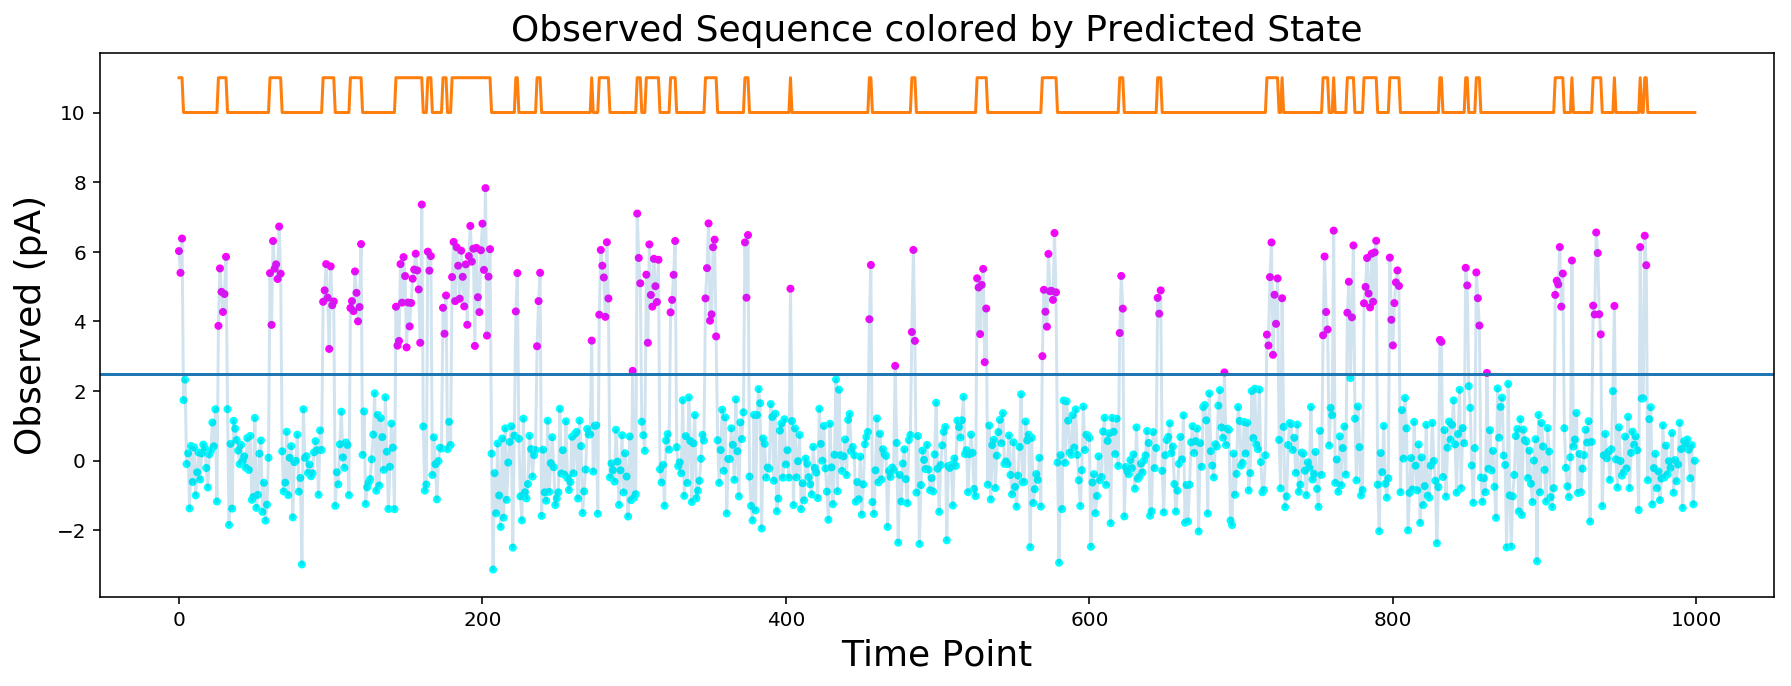

In [133]:
plt.plot(observations, alpha=0.2)
plt.scatter(range(len(observations)), observations, marker='.', c=predictedStates, cmap='cool')
plt.axhline(threshold)
plt.plot(states + 10)
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Observed Sequence colored by Predicted State');

# <font color=red> How well did thresholding do?

# <font color=red> Can you think of a case where thresholding won't work well?

## Other clustering methods such as GMMs, kmeans, etc. can also classify states by amplitude.

---
# Filtering and Missed Events

In [134]:
dt_ms = 0.1
fs_kHz = 1 / dt_ms
time_ms = np.arange(len(observations)) * dt_ms

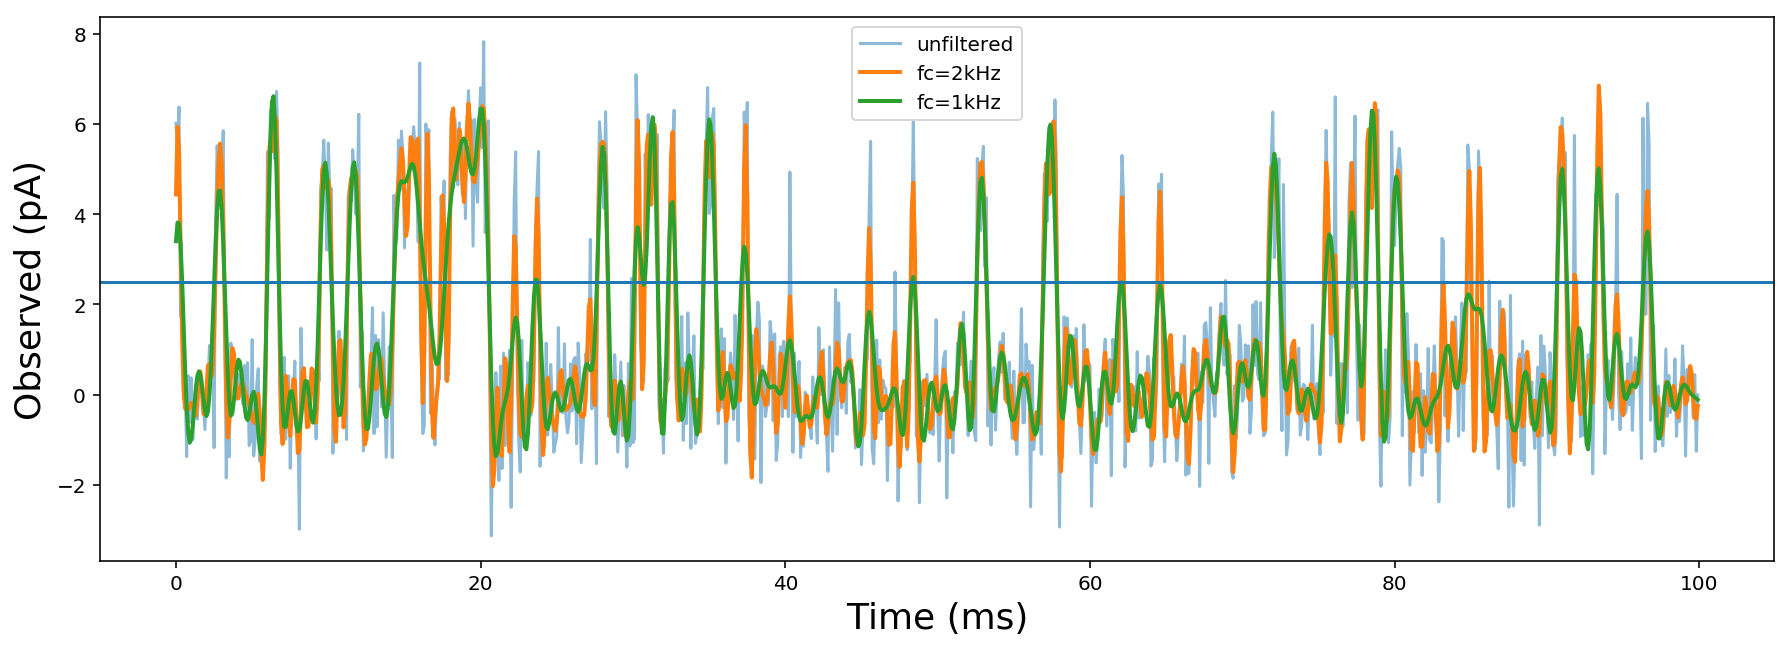

In [135]:
from scipy import signal

lowpass2kHz = signal.firwin(301, 2, nyq=fs_kHz/2)
lowpass1kHz = signal.firwin(301, 1, nyq=fs_kHz/2)

filtered2kHz = np.convolve(observations, lowpass2kHz, 'same')
filtered1kHz = np.convolve(observations, lowpass1kHz, 'same')

plt.plot(time_ms, observations, alpha=0.5, label='unfiltered')
plt.plot(time_ms, filtered2kHz, lw=2, label='fc=2kHz')
plt.plot(time_ms, filtered1kHz, lw=2, label='fc=1kHz')
plt.axhline(threshold)
plt.xlabel('Time (ms)')
plt.ylabel('Observed (pA)');
plt.legend();

# <font color=red> Examine the plot and see if you can think of a pro and a con of filtering.

---
# 3-State (Closed $\rightleftarrows$ Open $\rightleftarrows$ Desensitized) HMM for an ion channel

### Starting probability in each state:

In [136]:
p0 = np.array([1, 0, 0])  # P(C), P(O), P(D)

### Transition probabilities per time step:

In [137]:
trans = np.array([[0.950, 0.050, 0.000],   # P(C->C), P(C->O), P(C->D)
                  [0.030, 0.950, 0.020],   # P(O->C), P(O->O), P(O->D)
                  [0.000, 0.004, 0.996]])  # P(D->C), P(D->O), P(D->D)

### Emission distributions for each state:

In [138]:
emis = [st.norm(0, 1), st.norm(5, 1), st.norm(0, 1)]

### Simulate some data for the HMM:

In [139]:
states, observations = simulateHMM(p0, trans, emis, 100000)

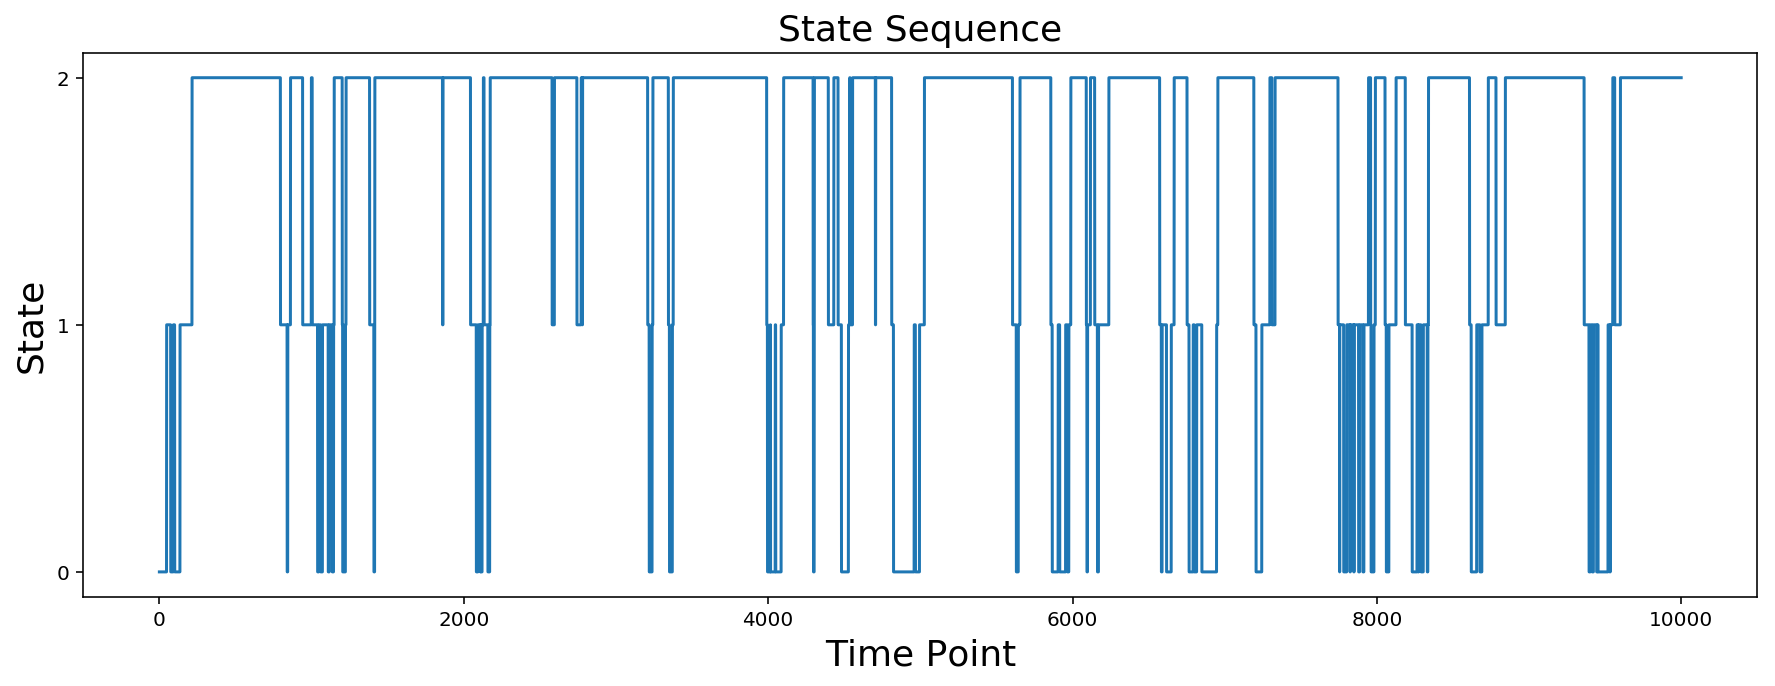

In [140]:
n = 10000
plt.plot(states[:n])
plt.yticks(np.unique(states))
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence');

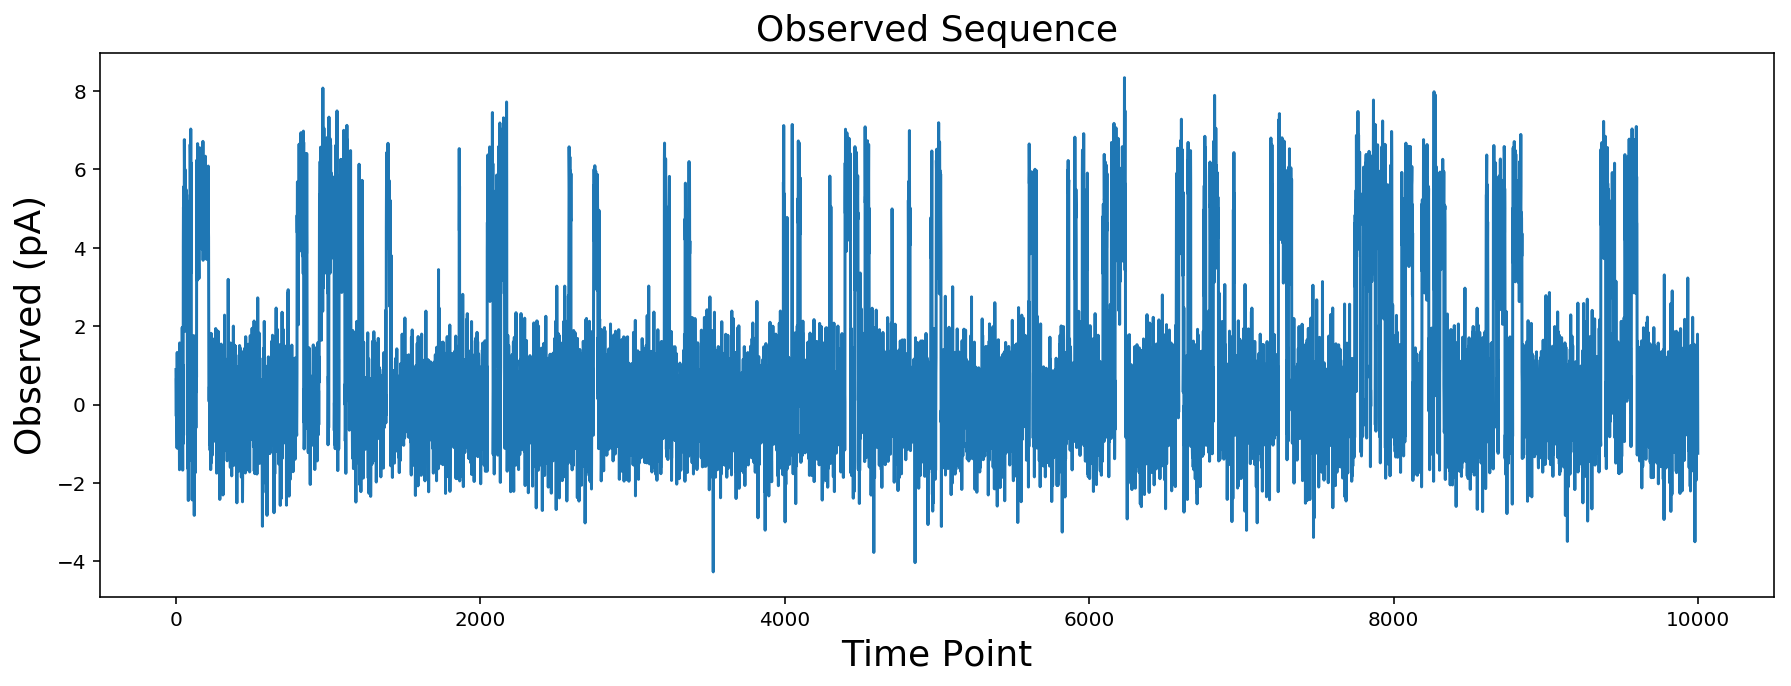

In [141]:
n = 10000
plt.plot(observations[:n])
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Observed Sequence');

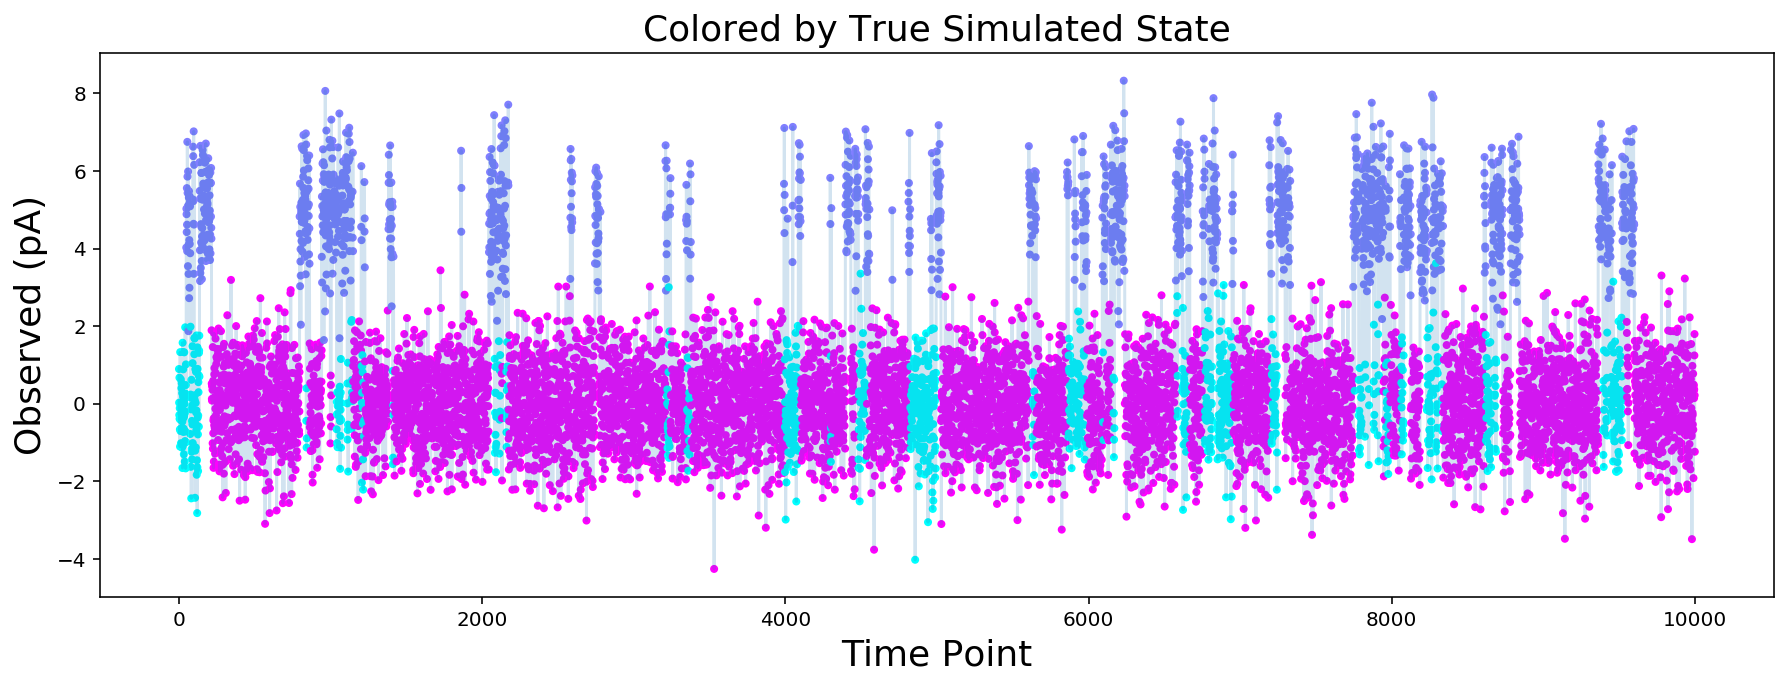

In [142]:
n = 10000
plt.plot(observations[:n], alpha=0.2)
plt.scatter(range(n), observations[:n], marker='.', c=states[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by True Simulated State');

---
# Dwell Time Distributions

In [143]:
dwelltimes = {}
for i in np.unique(states):
    dwelltimes[i] = []
for i, state in enumerate(states):
    if i > 0 and states[i-1] == state:
        dwelltimes[state][-1] += 1
    else:
        dwelltimes[state].append(1)

closedTimes = dwelltimes[0] + dwelltimes[2]
openTimes = dwelltimes[1]

dt_ms = 0.1
closedTimes_ms = np.array(closedTimes) * dt_ms
openTimes_ms = np.array(openTimes) * dt_ms

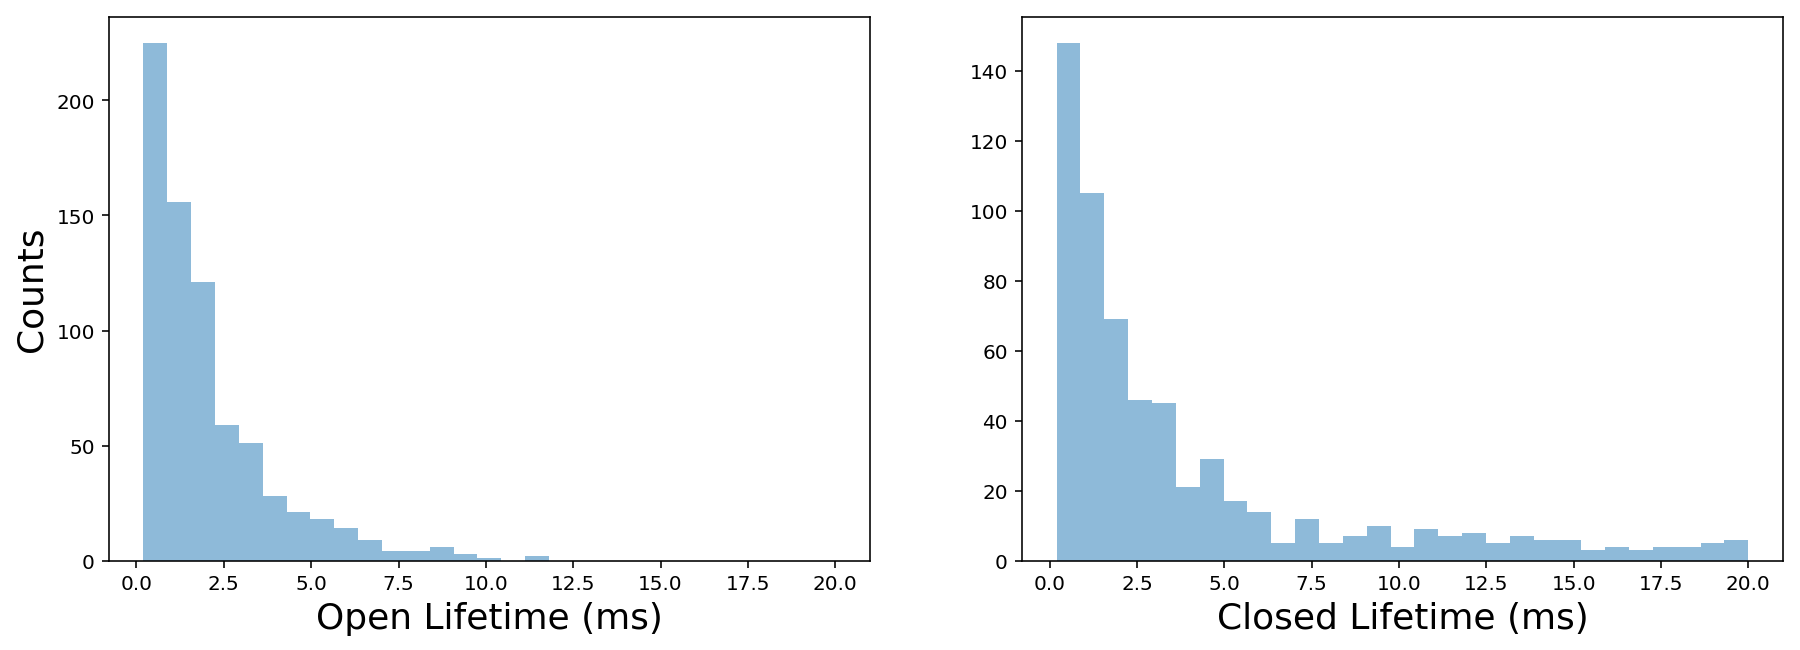

In [144]:
plt.subplot(121)
binedges = np.linspace(0.2, 20, 30)
plt.hist(openTimes_ms, binedges, alpha=0.5)
plt.xlabel('Open Lifetime (ms)')
plt.ylabel('Counts')

plt.subplot(122)
binedges = np.linspace(0.2, 20, 30)
plt.hist(closedTimes_ms, binedges, alpha=0.5)
plt.xlabel('Closed Lifetime (ms)');

# <font color=red> Dwelltimes are often binned and plotted on a logscale. Why do you think that is?

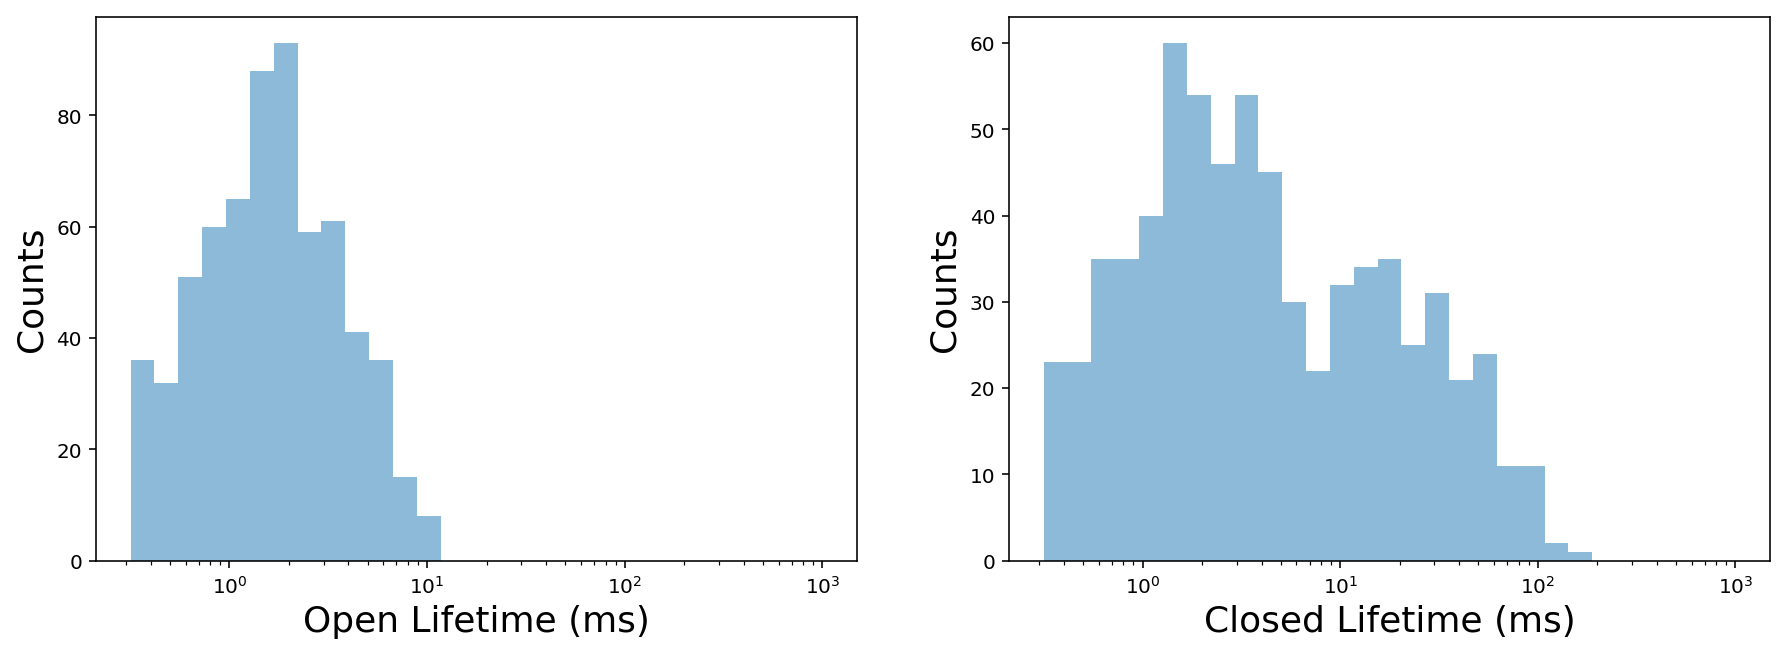

In [145]:
plt.subplot(121)
binedges = np.logspace(-0.5, 3, 30)
plt.hist(openTimes_ms, binedges, alpha=0.5)
plt.xlabel('Open Lifetime (ms)')
plt.ylabel('Counts')
plt.xscale('log')

plt.subplot(122)
binedges = np.logspace(-0.5, 3, 30)
plt.hist(closedTimes_ms, binedges, alpha=0.5)
plt.xlabel('Closed Lifetime (ms)')
plt.ylabel('Counts')
plt.xscale('log');

---
# Observtions $\rightarrow$ HMM

In [150]:
# conda install pomegranate
import pomegranate as pom
import pandas as pd

### Postulate a HMM to explain the observations.

In [148]:
hmm = pom.HiddenMarkovModel()

# states
C = pom.State(pom.NormalDistribution(0, 0.8), name='Closed')
O = pom.State(pom.NormalDistribution(5, 1), name='Open')
D = pom.State(pom.NormalDistribution(0, 0.8), name='Desensitized')
hmm.add_states([C, O, D])

# starting probability in each state
hmm.add_transition(hmm.start, C, 0.9)
hmm.add_transition(hmm.start, O, 0.1)

# transition probabilites per time step between states
hmm.add_transition(C, C, 0.90)
hmm.add_transition(C, O, 0.10)

hmm.add_transition(O, C, 0.05)
hmm.add_transition(O, O, 0.90)
hmm.add_transition(O, D, 0.05)

hmm.add_transition(D, O, 0.05)
hmm.add_transition(D, D, 0.95)

# we have to bake it before we can use it!
hmm.bake()

In [173]:
# !!! after we bake the HMM, the order of our states may be changed :(
# but we can easily get the new order from hmm.states
stateNames = [state.name for state in hmm.states]

# !!! None-start and None-end specify how state sequences start and end, but they are not actual states in the sequence
stateNames

['Closed', 'Desensitized', 'Open', 'None-start', 'None-end']

### Initial HMM parameters in Pandas tables. These are just the values we specified above.

In [160]:
trans = hmm.dense_transition_matrix()
pd.DataFrame(trans, index=stateNames, columns=stateNames)

,Closed,Desensitized,Open,None-start,None-end
Closed,0.90,0.00,0.10,0.0,0.0
Desensitized,0.00,0.95,0.05,0.0,0.0
Open,0.05,0.05,0.90,0.0,0.0
None-start,0.90,0.00,0.10,0.0,0.0
None-end,0.00,0.00,0.00,0.0,0.0


In [161]:
pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=stateNames[:3], columns=['mean', 'std'])

,mean,std
Closed,0.0,0.8
Desensitized,0.0,0.8
Open,5.0,1.0


### Probability that our initial postulated model explains our observations.

In [164]:
hmm.probability(observations)

0.0

In [165]:
hmm.probability(observations[:100])  # less points

2.816985999427816e-72

In [166]:
hmm.log_probability(observations)

-157074.22107524623

### Optimize the HMM parameters to best explain the first 10,000 time points of our observations.

In [167]:
hmm.fit([observations[:10000]], algorithm='baum-welch');

### Optimized HMM parameters in Pandas tables.

In [168]:
trans = hmm.dense_transition_matrix()
pd.DataFrame(trans, index=stateNames, columns=stateNames)

,Closed,Desensitized,Open,None-start,None-end
Closed,0.947015,0.000000,5.298515e-02,0.0,0.0
Desensitized,0.000000,0.995562,4.437764e-03,0.0,0.0
Open,0.033955,0.019400,9.466444e-01,0.0,0.0
None-start,1.000000,0.000000,3.807611e-188,0.0,0.0
None-end,0.000000,0.000000,0.000000e+00,0.0,0.0


In [169]:
pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=stateNames[:3], columns=['mean', 'std'])

,mean,std
Closed,0.010162,0.979737
Desensitized,-0.023501,0.994758
Open,4.998929,0.989301


### Probability that our optimized model explains our observations.

In [170]:
hmm.log_probability(observations)

-149331.8645914867

---
# Use the optimized HMM to predict the state sequence underlying the observations.

In [171]:
predictedStates = hmm.predict(observations)

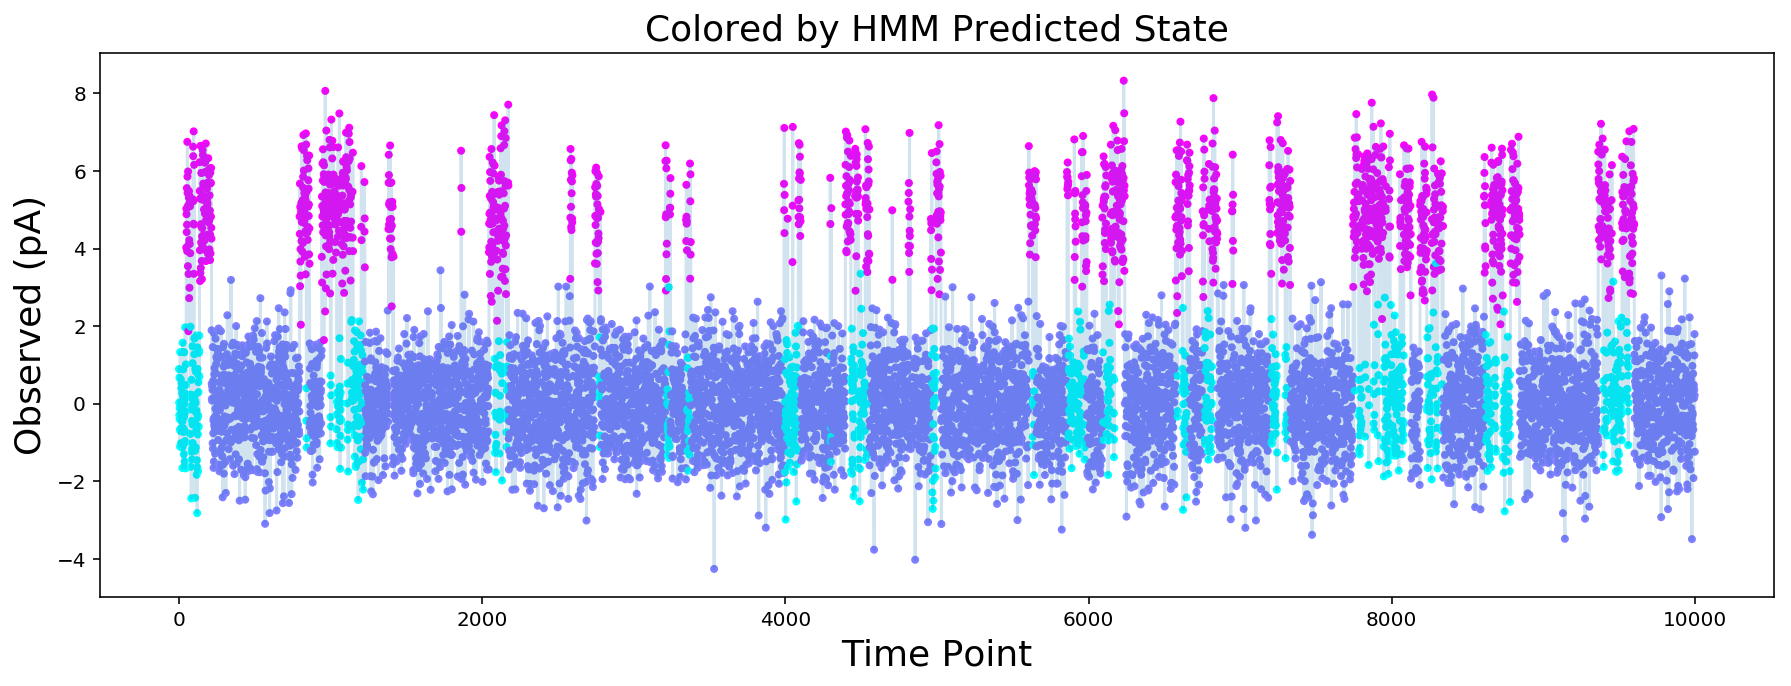

In [172]:
n = 10000
plt.plot(observations[:n], alpha=0.2)
plt.scatter(range(n), observations[:n], marker='.', c=predictedStates[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by HMM Predicted State');

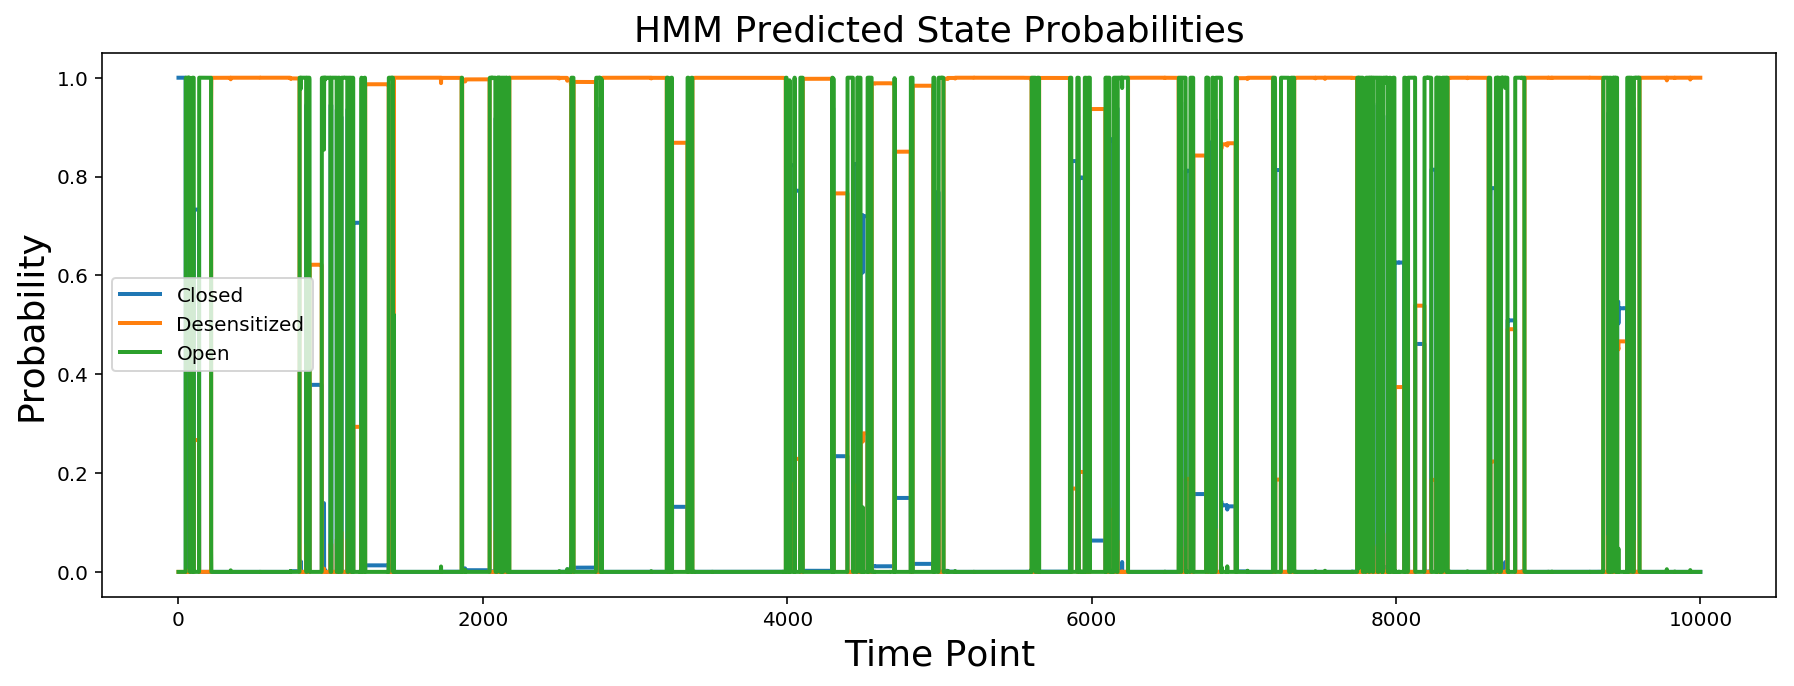

In [174]:
predictedStateProb = hmm.predict_proba(observations)

n = 10000
plt.plot(predictedStateProb[:n], lw=2)
plt.xlabel('Time Point')
plt.ylabel('Probability')
plt.title('HMM Predicted State Probabilities')
plt.legend(stateNames[:3]);

---
---
# <font color=red> Exercise Part 1

Using pomegranate build a model with 2-4 states whose emitted observations come from normal distributions and which are connected by up to 6 possible allowed transitions. You choose exactly how many states between 2 and 4, what the emission distribution parameters are for each state, and what the transition probabilites are between states. Please make the states distinct from each other in some way, either in emission or transition rate, but not necessarily both. Also make the probability of staying in each state per time step at leat 0.5, otherwise their lifetime will be too close to the sample frequency.

Simulate a sequence of at least 100,000 observations using your model.
    
### When you're done, hide/collapse all of the cells except for a plot of the simulated observations.

---
---
# <font color=red> Exercise Part 2

With a partner, look at each others simulated observations and each of you postulate a model that might explain your partners simulation. Direct your partner to build and optimize your postulated model to explain their simulation.
    
### How close did you come to the model your partner usd for the simulation?